<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/06a-random_forest_backtest.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Backtesting a Random Forest

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

## Outline

- Read data saved in 05a-fundamentals.ipynb
- Loop over specified training dates (e.g., once per year)
  - At each training date, train the random forest on prior data
  - Use the trained model to make predictions until the next training date
- Use the predictions to form portfolios
  - Best and worst stocks each week
  - Best and worst stocks in each sector each week
- Compare returns of equally weighted portfolios (long and short)  

- This is what we did last week, except
- Instead of combining value and momentum ranks, we make predictions based on
  - the model trained on prior data
  - more characteristics: marketcap, volume, volatility, ...

## Read data

In [1]:
import pandas as pd

# change path_to_file to "./" if the file is in your working directory
path_to_file = "../../"

df = pd.read_csv(path_to_file + "data-2023-11-08.csv")
df.head()

,ticker,date,marketcap,pb,ret,mom,volume,volatility,roe,accruals,agr,sector
0,AACC,2011-01-14,188.3,1.4,-0.014634,-0.184615,2.078000e+04,0.071498,-0.118239,-0.182275,0.004383,Financial Services
1,AAI,2011-01-14,1012.1,2.0,0.002677,0.438224,2.775580e+06,0.128450,0.108073,-0.220045,0.002237,Industrials
2,AAIC,2011-01-14,189.3,1.0,-0.010119,0.684547,3.466000e+04,0.048505,0.136967,0.108055,0.135697,Real Estate
3,AAON,2011-01-14,479.4,4.2,0.007778,0.528685,2.817291e+05,0.044912,0.191801,-0.088557,0.011656,Basic Materials
4,AATC,2011-01-14,63.3,1.4,-0.013960,0.008216,6.800000e+03,0.049756,0.072269,-0.008792,0.089436,Technology


## Define model and target

In [2]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=3)

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: x - x.median()
)

## Define predictors (features)

In [3]:
features = [
    "marketcap", 
    "pb", 
    "mom", 
    "volume", 
    "volatility", 
    "roe", 
    "accruals"
]

## Define training dates

In [4]:
# how many weeks to use for the initial fitting of the model
initial_weeks = 52

# how frequent to retrain the model
# retrain_weeks=4 means every four weeks, retrain_weeks=52 means once per year, ...
retrain_weeks = 52

dates = df.date.unique()
dates.sort()
train_dates = dates[initial_weeks::retrain_weeks]
train_dates

array(['2012-01-13', '2013-01-11', '2014-01-10', '2015-01-09',
       '2016-01-08', '2017-01-06', '2018-01-05', '2019-01-04',
       '2020-01-03', '2020-12-31', '2021-12-31', '2022-12-30'],
      dtype=object)

## Run the loop

In [5]:
predict_dates = {}
for i, date in enumerate(train_dates[:-1]):
    predict_dates[date] = [d for d in dates if d>date and d<=train_dates[i+1]]
predict_dates[train_dates[-1]] = [d for d in dates if d>train_dates[-1]]

In [6]:
new_data = None
for train_date in train_dates:
    past = df[df.date<=train_date]
    future = df[df.date.isin(predict_dates[train_date])]
    forest.fit(X=past[features], y=past.target)
    predictions = forest.predict(X=future[features])
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["predict"]
    for col in ["ticker", "date"]:
        predictions[col] = future[col].to_list()
    new_data = pd.concat((new_data, predictions))
df = df.merge(new_data, on=["ticker", "date"], how="inner")

In [7]:
df.tail()

,ticker,date,marketcap,pb,ret,mom,volume,volatility,roe,accruals,agr,sector,target,predict
1214407,ZNTL,2023-11-06,1262.5,2.4,-0.302013,-0.174662,743655.8,0.086553,-0.627662,-0.179132,0.025936,Healthcare,-0.292998,0.001431
1214408,ZUMZ,2023-11-06,335.0,0.9,-0.023063,-0.245402,201904.4,0.053633,-0.021791,-0.020549,-0.004926,Consumer Cyclical,-0.014048,0.001431
1214409,ZUO,2023-11-06,1088.9,9.7,-0.011613,0.080163,662494.2,0.070317,-1.501578,-1.478702,0.007839,Technology,-0.002598,0.001431
1214410,ZYME,2023-11-06,504.0,1.1,-0.020188,-0.215539,435386.8,0.062766,0.466608,0.053474,0.121481,Healthcare,-0.011173,0.001431
1214411,ZYXI,2023-11-06,310.4,5.3,0.014746,-0.356304,379338.0,0.066363,0.253785,-0.005658,0.072638,Healthcare,0.023761,0.001431


## Form portfolios and compute returns

In [8]:
df["rnk_long"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=True,
    method="first"
)
longs = df[df.rnk_long<=44]
shorts = df[df.rnk_short<=44]

In [9]:
long_ret = longs.groupby("date").ret.mean()
short_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long return is {52*long_ret.mean():.2%}")
print(f"mean annualized short return is {52*short_ret.mean():.2%}")

mean annualized long return is 47.21%
mean annualized short return is -19.79%


## Try sector-neutral strategy

In [10]:
df["rnk_long"] = df.groupby(["date", "sector"], group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby(["date", "sector"], group_keys=False).predict.rank(
    ascending=True,
    method="first"
)
longs = df[df.rnk_long<=4]
shorts = df[df.rnk_short<=4]

In [11]:
long_neutral_ret = longs.groupby("date").ret.mean()
short_neutral_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long sector-neutral return is {52*long_neutral_ret.mean():.2%}")
print(f"mean annualized short sector-neutral return is {52*short_neutral_ret.mean():.2%}")

mean annualized long sector-neutral return is 43.00%
mean annualized short sector-neutral return is -8.86%


## Plot long-minus-short returns

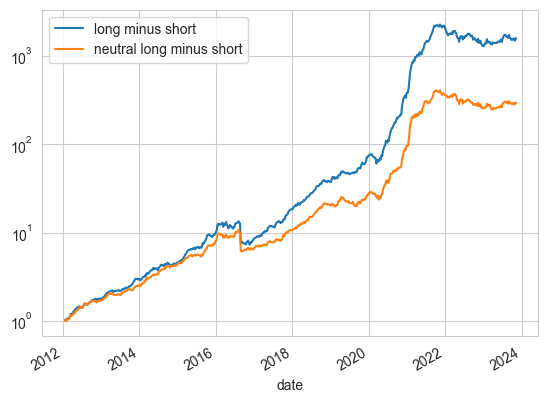

In [15]:
lms = long_ret - short_ret
lms_neutral = long_neutral_ret - short_neutral_ret

lms.index = pd.to_datetime(lms.index)
lms_neutral.index = pd.to_datetime(lms_neutral.index)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

(1+lms).cumprod().plot(logy=True, label="long minus short")
(1+lms_neutral).cumprod().plot(logy=True, label="neutral long minus short")
plt.legend()
plt.show()